# **In the name of Allah**

**ADSP final project**

**student**:Hadi Alizadeh

**subject**: ICA


In [1]:
# instaltion and Imports
!pip install rir_generator
import numpy as np
import scipy.signal as ss
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import itertools
import rir_generator as rir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Defination required function

In [2]:
def projection_back(Y, reference):
    """
    Args:
        Y: (n_sources, n_bins, n_frames)
        reference: (n_bins, n_frames) or (n_channels, n_bins, n_frames)
    Returns:
        scale: (n_sources, n_bins) or (n_channels, n_sources, n_bins)
    """
    # pseudo inverse
    n_dims = reference.ndim
    if n_dims == 2:
        # Y: (n_sources, n_bins, n_frames)
        # X: (1, n_bins, n_frames)
        X = reference[np.newaxis,:,:].transpose(1, 0, 2) # (n_bins, n_channels, n_frames)
        Y = Y.transpose(1, 0, 2) # (n_bins, n_sources, n_frames)
        Y_Hermite = Y.transpose(0, 2, 1).conj() # (n_bins, n_frames, n_sources)
        YY_Hermite_inverse = np.linalg.inv(Y @ Y_Hermite) # (n_bins, n_sources, n_sources)
        A = X @ Y_Hermite @ YY_Hermite_inverse # (n_bins, n_channels, n_sources)
        scale = A[:,0,:].transpose(1, 0) # (n_sources, n_bins)
    elif n_dims == 3:
        # Y: (n_sources, n_bins, n_frames)
        # X: (n_channels, n_bins, n_frames)
        X = reference.transpose(1, 0, 2) # (n_bins, n_channels, n_frames)
        Y = Y.transpose(1, 0, 2) # (n_bins, n_sources, n_frames)
        Y_Hermite = Y.transpose(0, 2, 1).conj() # (n_bins, n_frames, n_sources)
        YY_Hermite_inverse = np.linalg.inv(Y @ Y_Hermite) # (n_bins, n_sources, n_sources)
        A = X @ Y_Hermite @ YY_Hermite_inverse # (n_bins, n_channels, n_sources)
        scale = A.transpose(1, 2, 0) # (n_channels, n_sources, n_bins)
    else:
        raise ValueError("reference.ndim is expected 2 or 3, but given {}.".format(n_dims))

    return scale


In [3]:
# ica
EPS=1e-12
class ICAbase:
    def __init__(self, callbacks=None, recordable_loss=True, eps=EPS):
        if callbacks is not None:
            if callable(callbacks):
                callbacks = [callbacks]
            self.callbacks = callbacks
        else:
            self.callbacks = None
        self.eps = eps

        self.input = None
        self.criterion = None
        self.recordable_loss = recordable_loss
        if self.recordable_loss:
            self.loss = []
        else:
            self.loss = None

    def _reset(self, **kwargs):
        assert self.input is not None, "Specify data!"

        for key in kwargs.keys():
            setattr(self, key, kwargs[key])

        X = self.input

        n_channels, n_bins, n_frames = X.shape
        n_sources = n_channels # n_channels == n_sources

        self.n_sources, self.n_channels = n_sources, n_channels
        self.n_bins, self.n_frames = n_bins, n_frames

        if not hasattr(self, 'demix_filter'):
            W = np.eye(n_sources, n_channels, dtype=np.complex128)
            self.demix_filter = np.tile(W, reps=(n_bins, 1, 1))
        else:
            W = self.demix_filter.copy()
            self.demix_filter = W
        self.estimation = self.separate(X, demix_filter=W)
        
    def __call__(self, input, iteration=100, **kwargs):
        """
        Args:
            input (n_channels, n_bins, n_frames)
        Returns:
            output (n_channels, n_bins, n_frames)
        """
        self.input = input

        self._reset(**kwargs)

        if self.recordable_loss:
            loss = self.compute_negative_loglikelihood()
            self.loss.append(loss)
        
        if self.callbacks is not None:
            for callback in self.callbacks:
                callback(self)

        for idx in range(iteration):
            self.update_once()

            if self.recordable_loss:
                loss = self.compute_negative_loglikelihood()
                self.loss.append(loss)
            
            if self.callbacks is not None:
                for callback in self.callbacks:
                    callback(self)
        
        X, W = input, self.demix_filter
        output = self.separate(X, demix_filter=W)

        return output
    
    def __repr__(self) -> str:
        s = "ICA()"
        

        return s.format(**self.__dict__)

    def update_once(self):
        raise NotImplementedError("Implement 'update' function")
    
    def separate(self, input, demix_filter):
        """
        Args:
            input (n_channels, n_bins, n_frames): 
            demix_filter (n_bins, n_sources, n_channels): 
        Returns:
            output (n_channels, n_bins, n_frames): 
        """
        input = input.transpose(1,0,2)
        estimation = demix_filter @ input
        output = estimation.transpose(1,0,2)

        return output

    def solve_permutation(self):
        n_sources, n_bins, n_frames = self.n_sources, self.n_bins, self.n_frames
        eps = self.eps

        permutations = list(itertools.permutations(range(n_sources))) 

        W = self.demix_filter # (n_bins, n_sources, n_chennels)
        Y = self.estimation # (n_sources, n_bins, n_frames)

        P = np.abs(Y).transpose(1,0,2) # (n_bins, n_sources, n_frames)
        norm = np.sqrt(np.sum(P**2, axis=1, keepdims=True))
        norm[norm < eps] = eps
        P = P / norm # (n_bins, n_sources, n_frames)
        correlation = np.sum(P @ P.transpose(0,2,1), axis=(1,2)) # (n_sources,)
        indices = np.argsort(correlation) # ouput is position of sort

        min_idx = indices[0]
        P_criteria = P[min_idx] # (n_sources, n_frames)

        for idx in range(1, n_bins):
            min_idx = indices[idx]
            P_max = None
            perm_max = None
            for perm in permutations:
                P_perm = np.sum(P_criteria * P[min_idx, perm,:])
                if P_max is None or P_perm > P_max:
                    P_max = P_perm
                    perm_max = perm
            
            P_criteria = P_criteria + P[min_idx,perm_max,:]
            W[min_idx,:,:] = W[min_idx,perm_max,:]
        
        self.demix_filter = W
    
    def compute_negative_loglikelihood(self):
        raise NotImplementedError("Implement 'compute_negative_loglikelihood' function.")


class GradICAbase(ICAbase):
    def __init__(self, lr=1e-1, reference_id=0, callbacks=None, recordable_loss=True, eps=EPS):
        super().__init__(callbacks=callbacks, recordable_loss=recordable_loss, eps=eps)

        self.lr = lr
        self.reference_id = reference_id
    
    def __call__(self, input, iteration=100, **kwargs):
        """
        Args:
            input (n_channels, n_bins, n_frames)
        Returns:
            output (n_channels, n_bins, n_frames)
        """
        self.input = input

        self._reset(**kwargs)

        if self.recordable_loss:
            loss = self.compute_negative_loglikelihood()
            self.loss.append(loss)

        if self.callbacks is not None:
            for callback in self.callbacks:
                callback(self)

        for idx in range(iteration):
            self.update_once()

            if self.recordable_loss:
                loss = self.compute_negative_loglikelihood()
                self.loss.append(loss)
            
            if self.callbacks is not None:
                for callback in self.callbacks:
                    callback(self)
        
        self.solve_permutation()

        reference_id = self.reference_id
        X, W = input, self.demix_filter
        Y = self.separate(X, demix_filter=W)

        scale = projection_back(Y, reference=X[reference_id])
        output = Y * scale[...,np.newaxis] # (n_sources, n_bins, n_frames)
        self.estimation = output

        return output
    
    def __repr__(self) -> str:
        s = "GradICA(lr={lr})"

        return s.format(**self.__dict__)
    
    def compute_negative_loglikelihood(self):
        raise NotImplementedError("Implement 'compute_negative_loglikelihood' function.")


class NaturalGradICA(GradICAbase):
    def __init__(self, lr=1e-1, reference_id=0, is_holonomic=True, callbacks=None, recordable_loss=True, eps=EPS):
        super().__init__(lr=lr, reference_id=reference_id, callbacks=callbacks, recordable_loss=recordable_loss, eps=eps)

        self.is_holonomic = is_holonomic

    def update_once(self):
        n_sources, n_channels = self.n_sources, self.n_channels
        n_frames = self.n_frames
        lr = self.lr
        eps = self.eps

        X = self.input
        W = self.demix_filter
        Y = self.separate(X, demix_filter=W)
        eye = np.eye(n_sources, n_channels, dtype=np.complex128)

        Y = Y.transpose(1,0,2) # (n_bins, n_sources, n_frames)
        Y_Hermite = Y.transpose(0,2,1).conj() # (n_bins, n_frames, n_sources)
        denominator = np.abs(Y)
        denominator[denominator < eps] = eps
        Phi = Y / denominator # (n_bins, n_sources, n_frames)

        if self.is_holonomic:
            delta = ((Phi @ Y_Hermite) / n_frames - eye) @ W
        else:
            raise NotImplementedError("only suports for is_holonomic = True")
            offdiag_mask = 1 - eye
            delta = offdiag_mask * ((Phi @ Y_Hermite) / n_frames) @ W
        
        W = W - lr * delta # (n_bins, n_sources, n_channels)

        Y = self.separate(X, demix_filter=W)

        self.demix_filter = W
        self.estimation = Y
    
    def compute_negative_loglikelihood(self):
        X, W = self.input, self.demix_filter
        Y = self.separate(X, demix_filter=W)

        loss = 2 * np.abs(Y).sum(axis=0).mean(axis=1) - 2 * np.log(np.abs(np.linalg.det(W)))
        loss = loss.sum()

        return loss



In [4]:
#  read and write
from scipy.io import wavfile
import numpy as np

def read_wav(path):
    sr, signal = wavfile.read(path)
    signal = signal / 32768
    
    return signal, sr

def write_wav(path, signal, sr, channel_last=True):
    signal = signal * 32768
    signal = np.clip(signal, -32768, 32767).astype(np.int16)

    if not signal.ndim in [1, 2]:
        raise ValueError("Only support 1D or 2D input.")
    if signal.ndim == 2 and not channel_last:
        signal = signal.transpose()
    wavfile.write(path, sr, signal)

## **Room impulse response defination**

The room impulse for speaker1

In [5]:
# Room impulse response for 1 person

def Impulse1(A):
  signal, fs = sf.read(A, always_2d=True)

  h = rir.generate(
    c=340,                  # Sound velocity (m/s)
    fs=fs,                  # Sample frequency (samples/s)
    r=[                     # Receiver position(s) [x y z] (m)
        [3, 2 , 1],
        [3, 4 , 1]
       
    ],
    s=[2,2, 2],          # Source position [x y z] (m)
    L=[6, 6, 3],            # Room dimensions [x y z] (m)
    reverberation_time=0.16, # Reverberation time (s)
    nsample=4096,           # Number of output samples
  )

  #print(h.shape)               
  #print(signal.shape)         

  # Convolve 2-channel signal with 3 impulse responses
  signal = ss.convolve(h[:, None, :], signal[:, :, None])
  #print(signal.shape)
  
  return signal,fs

The room impulse for speaker2

In [6]:
# Room impulse response for 2th person

def Impulse2(A):
  signal, fs = sf.read(A, always_2d=True)

  h = rir.generate(
    c=340,                  # Sound velocity (m/s)
    fs=fs,                  # Sample frequency (samples/s)
    r=[                     # Receiver position(s) [x y z] (m)
        [3, 2 , 1],
        [3, 4 , 1]
       
    ],
    s=[5, 2, 1],          # Source position [x y z] (m)
    L=[6, 6, 3],            # Room dimensions [x y z] (m)
    reverberation_time=0.16, # Reverberation time (s)
    nsample=4096,           # Number of output samples
  )

  #print(h.shape)               
  #print(signal.shape)         

  # Convolve 2-channel signal with 3 impulse responses
  signal = ss.convolve(h[:, None, :], signal[:, :, None])
  #print(signal.shape)
  v=signal[:,0:1]
        
  return signal,fs

- convolve input voice to room impulse response
- creat mix of speeches (x)

In [7]:
speaker1, sr = Impulse1("/content/weman.wav")
speaker2, sr = Impulse2("/content/man.wav")

m=min(len(speaker1),len(speaker2))

mic1=speaker2[:m,0,0]+speaker1[:m,0,0]
mic2=speaker2[:m,0,1]+speaker1[:m,0,1]

x = np.vstack([mic1, mic2])
n_channels, T = x.shape
n_sources = n_channels

## **play crated audio**

In [8]:
display(ipd.Audio(mic1, rate=sr))
display(ipd.Audio(mic2, rate=sr))
display(ipd.Audio(x, rate=sr))

## **STFT of in put signal (x)**

In [9]:
# setup of stft
fft_size, hop_size = 4096, 2048

In [10]:
_, _, X = ss.stft(x, nperseg=fft_size, noverlap=fft_size-hop_size)

## **Starting to sources separation**

In [11]:
# calling NaturalGradICA
np.random.seed(111)
ica = NaturalGradICA()

In [12]:
# using ica to separation by 200 iteration
# if some time this get "singular input" error run this block again
loss=0
Y = ica(X, iteration=200)

In [13]:
_, y = ss.istft(Y, nperseg=fft_size, noverlap=fft_size-hop_size)
y = y[:,:T]

In [14]:
for idx in range(n_sources):
    display(ipd.Audio(y[idx], rate=sr))

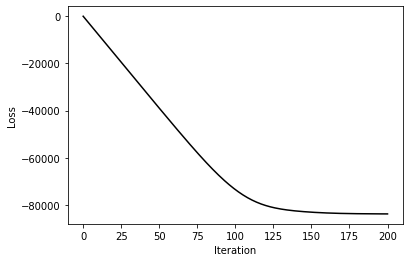

In [15]:
plt.figure()
plt.plot(ica.loss, color='black')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [16]:
write_wav("/content/source1.wav", y[0], sr, channel_last=True)
write_wav("/content/source2.wav", y[1], sr, channel_last=True)
write_wav("/content/mix.wav", x[0], sr, channel_last=True)